In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import featuretools as ft
import helper_functions as hf
import torch
from tqdm import tqdm
from datetime import datetime, timedelta
import talib
import ta
from ta.utils import dropna
from ta import add_all_ta_features
import matplotlib as mpl
mpl.style.use('seaborn')

/home/aymane/Kaggle/jpx-2022/venv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
stock_prices    = pd.read_csv("modified_data/stock_prices_adjusted.csv")
# financials      = pd.read_csv("modified_data/financials.csv")
# options         = pd.read_csv("modified_data/options.csv")
# secondary       = pd.read_csv("modified_data/secondary_stock_prices.csv")
# stock_list      = pd.read_csv("modified_data/tokenized_stock_list.csv")
# trades          = pd.read_csv("modified_data/trades.csv")

In [3]:
def RSI(series, period):
    delta = series.diff().dropna()
    u = delta * 0
    d = u.copy()
    u[delta > 0] = delta[delta > 0]
    d[delta < 0] = -delta[delta < 0]
    u[u.index[period-1]] = np.mean( u[:period] ) #first value is sum of avg gains
    u = u.drop(u.index[:(period-1)])
    d[d.index[period-1]] = np.mean( d[:period] ) #first value is sum of avg losses
    d = d.drop(d.index[:(period-1)])
    rs = pd.DataFrame.ewm(u, com=period-1, adjust=False).mean() / \
         pd.DataFrame.ewm(d, com=period-1, adjust=False).mean()
    return 100 - 100 / (1 + rs)

def rsi_class(x):
    ret = "low"
    if x < 50:
        ret = "low"
    if x > 50:
        ret = "med"
    if x > 70:
        ret = "hi"
    return(ret)

def atr(high, low, close):
    x1 = high - low
    x2 = abs(high - close.shift())
    x3 = abs(low - close.shift())
    ranges = pd.concat([x1, x2, x3], axis=1)
    tr = np.max(ranges, axis = 1)
    atr = tr.rolling(14).sum()/14
    return atr 

In [4]:
# sns.set(rc={'figure.figsize':(20,5)})
# sns.set_style("whitegrid")
# seclist = stock_prices["SecuritiesCode"][:10]
# for SECURITY in seclist:
#     df_stock = stock_prices[stock_prices['SecuritiesCode'] == SECURITY].reset_index(drop = True)
#     df_stock = df_stock.sort_values(by = "Date").reset_index()
#     df_stock['rsi'] = RSI( df_stock['Close'], 14 )
#     df_stock['rsicat'] = list(map(rsi_class, df_stock['rsi']))
#     plt.title(f"Examining RSI on movement of Price for:{SECURITY}")
#     ax = sns.scatterplot(x = df_stock.index, y = df_stock["Close"], hue = df_stock["rsicat"]);
#     plt.show()

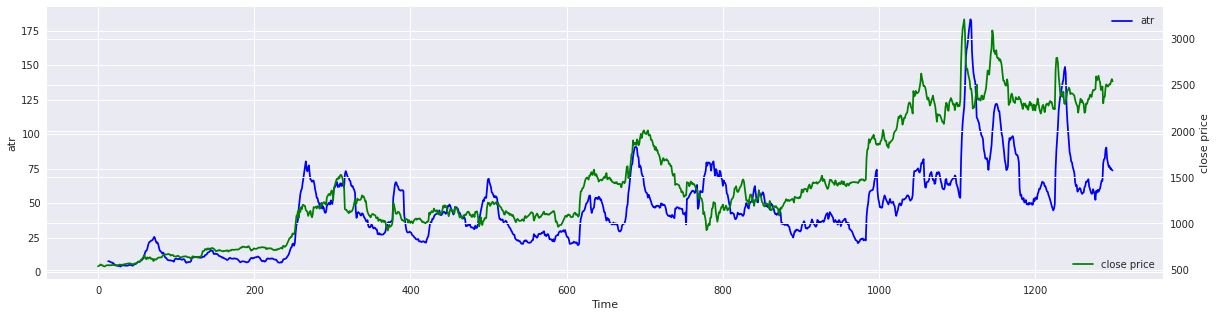

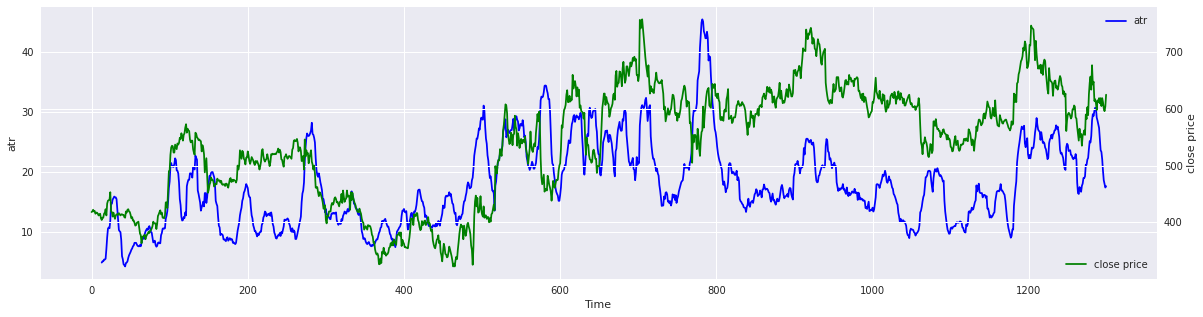

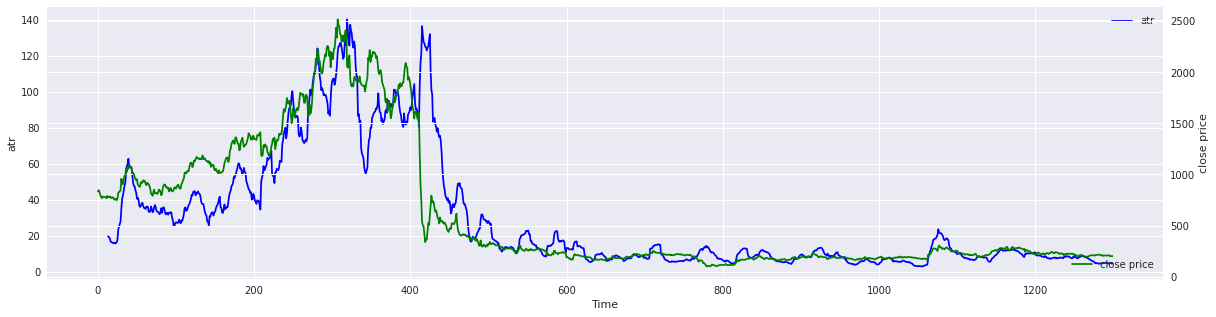

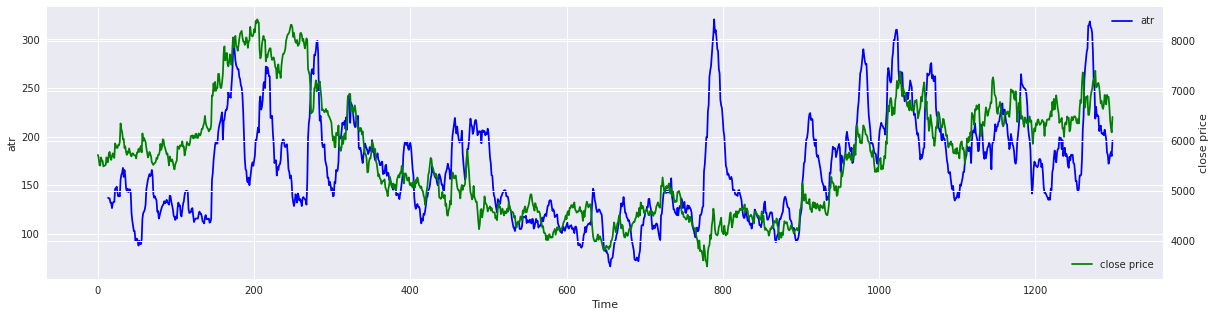

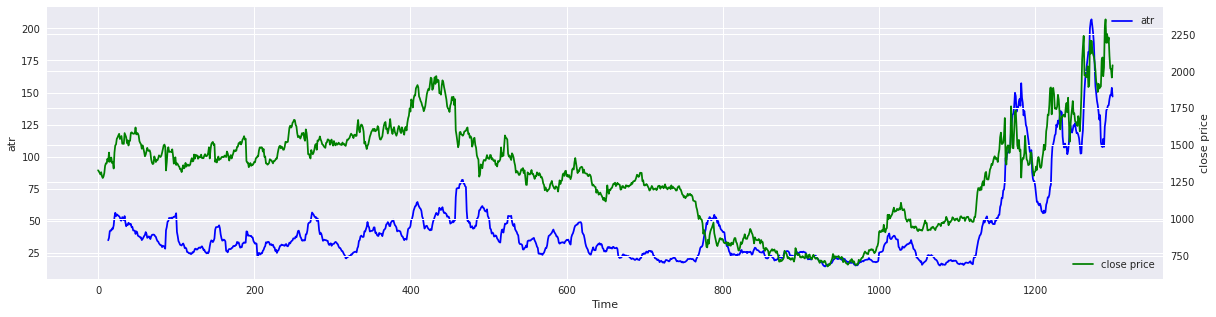

In [5]:
seclist = stock_prices["SecuritiesCode"][10:15]
for SECURITY in seclist:
    df_stock = stock_prices[stock_prices['SecuritiesCode'] == SECURITY].reset_index(drop = True)
    df_stock_high  = df_stock["AdjustedHigh"]
    df_stock_low   = df_stock["AdjustedLow"]
    df_stock_close = df_stock["AdjustedClose"]

    atr_final = atr(df_stock_high, df_stock_low, df_stock_close)
    fig, ax = plt.subplots(figsize= (20, 5))

    ax1 = ax.twinx()
    ax.plot(atr_final, label="atr", color="blue")
    ax.legend(loc="upper right")
    ax1.plot(df_stock_close, label="close price", color="green")
    ax1.legend(loc="lower right")

    ax.set_xlabel('Time')
    ax.set_ylabel('atr')
    ax1.set_ylabel('close price')

In [10]:
def get_talib_features(df):
    """
    Get technical features from TA-Lib
    """
    op = df['AdjustedOpen']
    hi = df['AdjustedHigh']
    lo = df['AdjustedLow']
    cl = df['AdjustedClose']
    vo = df['Volume']
    
    # Overlap Studies
    df['BBANDS_upper'], df['BBANDS_middle'], df['BBANDS_lower'] = talib.BBANDS(cl, timeperiod=5, nbdevup=2, nbdevdn=2, matype=0)
    df['DEMA'] = talib.DEMA(cl, timeperiod=30)
    df['EMA'] = talib.EMA(cl, timeperiod=30)
    df['HT_TRENDLINE'] = talib.HT_TRENDLINE(cl)
    df['KAMA'] = talib.KAMA(cl, timeperiod=30)
    df['MA'] = talib.MA(cl, timeperiod=30, matype=0)
    df['MIDPOINT'] = talib.MIDPOINT(cl, timeperiod=14)
    df['SAR'] = talib.SAR(hi, lo, acceleration=0, maximum=0)
    df['SAREXT'] = talib.SAREXT(hi, lo, startvalue=0, offsetonreverse=0, accelerationinitlong=0, accelerationlong=0, accelerationmaxlong=0, accelerationinitshort=0, accelerationshort=0, accelerationmaxshort=0)
    df['SMA'] = talib.SMA(cl, timeperiod=30)
    df['T3'] = talib.T3(df['AdjustedClose'], timeperiod=5, vfactor=0)
    df['TEMA'] = talib.TEMA(df['AdjustedClose'], timeperiod=30)
    df['TRIMA'] = talib.TRIMA(df['AdjustedClose'], timeperiod=30)
    df['WMA'] = talib.WMA(df['AdjustedClose'], timeperiod=30)
    
    # Momentum Indicators
    df['ADX'] = talib.ADX(hi, lo, cl, timeperiod=14)
    df['ADXR'] = talib.ADXR(hi, lo, cl, timeperiod=14)
    df['APO'] = talib.APO(cl, fastperiod=12, slowperiod=26, matype=0)
    df['AROON_down'], df['AROON_up'] = talib.AROON(hi, lo, timeperiod=14)
    df['AROONOSC'] = talib.AROONOSC(hi, lo, timeperiod=14)
    df['BOP'] = talib.BOP(op, hi, lo, cl)
    df['CCI'] = talib.CCI(hi, lo, cl, timeperiod=14)
    df['DX'] = talib.DX(hi, lo, cl, timeperiod=14)
    df['MACD_macd'], df['MACD_macdsignal'], df['MACD_macdhist'] = talib.MACD(cl, fastperiod=12, slowperiod=26, signalperiod=9)
    df['MFI'] = talib.MFI(hi, lo, cl, vo, timeperiod=14)
    df['MINUS_DI'] = talib.MINUS_DI(hi, lo, cl, timeperiod=14)
    df['MINUS_DM'] = talib.MINUS_DM(hi, lo, timeperiod=14)
    df['MOM'] = talib.MOM(cl, timeperiod=10)
    df['PLUS_DI'] = talib.PLUS_DI(hi, lo, cl, timeperiod=14)
    df['PLUS_DM'] = talib.PLUS_DM(hi, lo, timeperiod=14)
    df['RSI'] = talib.RSI(cl, timeperiod=14)
    df['STOCH_slowk'], df['STOCH_slowd'] = talib.STOCH(hi, lo, cl, fastk_period=5, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)
    df['STOCHF_fastk'], df['STOCHF_fastd'] = talib.STOCHF(hi, lo, cl, fastk_period=5, fastd_period=3, fastd_matype=0)
    df['STOCHRSI_fastk'], df['STOCHRSI_fastd'] = talib.STOCHRSI(cl, timeperiod=14, fastk_period=5, fastd_period=3, fastd_matype=0)
    df['TRIX'] = talib.TRIX(cl, timeperiod=30)
    df['ULTOSC'] = talib.ULTOSC(hi, lo, cl, timeperiod1=7, timeperiod2=14, timeperiod3=28)
    df['WILLR'] = talib.WILLR(hi, lo, cl, timeperiod=14)
    
    # Volume Indicators
    df['AD'] = talib.AD(hi, lo, cl, vo)
    df['ADOSC'] = talib.ADOSC(hi, lo, cl, vo, fastperiod=3, slowperiod=10)
    df['OBV'] = talib.OBV(cl, vo)
    
    # Volatility Indicators
    df['ATR'] = talib.ATR(hi, lo, cl, timeperiod=14)
    df['NATR'] = talib.NATR(hi, lo, cl, timeperiod=14)
    df['TRANGE'] = talib.TRANGE(hi, lo, cl)
    
    # Cycle Indicators
    df['HT_DCPERIOD'] = talib.HT_DCPERIOD(cl)
    df['HT_DCPHASE'] = talib.HT_DCPHASE(cl)
    df['HT_PHASOR_inphase'], df['HT_PHASOR_quadrature'] = talib.HT_PHASOR(cl)
    df['HT_SINE_sine'], df['HT_SINE_leadsine'] = talib.HT_SINE(cl)
    df['HT_TRENDMODE'] = talib.HT_TRENDMODE(cl)
    
    # Statistic Functions
    df['BETA'] = talib.BETA(hi, lo, timeperiod=5)
    df['CORREL'] = talib.CORREL(hi, lo, timeperiod=30)
    df['LINEARREG'] = talib.LINEARREG(cl, timeperiod=14) - cl
    df['LINEARREG_ANGLE'] = talib.LINEARREG_ANGLE(cl, timeperiod=14)
    df['LINEARREG_INTERCEPT'] = talib.LINEARREG_INTERCEPT(cl, timeperiod=14) - cl
    df['LINEARREG_SLOPE'] = talib.LINEARREG_SLOPE(cl, timeperiod=14)
    df['STDDEV'] = talib.STDDEV(cl, timeperiod=5, nbdev=1)   
    
    return df

In [11]:
%%time
results = stock_prices.groupby('SecuritiesCode').apply(get_talib_features)
results
results.to_csv("autoencoder_data")

CPU times: user 28.1 s, sys: 808 ms, total: 28.9 s
Wall time: 29 s


,Date,Unnamed: 0,RowId,SecuritiesCode,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target,CumulativeAdjustmentFactor,...,HT_SINE_sine,HT_SINE_leadsine,HT_TRENDMODE,BETA,CORREL,LINEARREG,LINEARREG_ANGLE,LINEARREG_INTERCEPT,LINEARREG_SLOPE,STDDEV
0,2017-01-04,0,20170104_1301,1301,31400,1.0,NaN,False,0.000730,1.0,...,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2017-01-04,1,20170104_1332,1332,2798500,1.0,NaN,False,0.012324,1.0,...,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2017-01-04,2,20170104_1333,1333,270800,1.0,NaN,False,0.006154,1.0,...,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2017-01-04,3,20170104_1376,1376,11300,1.0,NaN,False,0.011053,1.0,...,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2017-01-04,4,20170104_1377,1377,150800,1.0,NaN,False,0.003026,1.0,...,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2528519,2022-04-28,195988,20220428_9990,9990,51900,1.0,NaN,False,0.024048,1.0,...,0.859538,0.969168,0,0.548732,0.969236,-7.971429,46.050614,-21.457143,1.037363,6.615134
2528520,2022-04-28,195989,20220428_9991,9991,23400,1.0,NaN,False,0.011378,1.0,...,0.556496,0.981002,1,1.088098,0.992734,-1.000000,-23.198591,4.571429,-0.428571,5.607138
2528521,2022-04-28,195990,20220428_9993,9993,8100,1.0,NaN,False,-0.005941,1.0,...,-0.147498,0.595076,1,-0.292301,0.942285,6.057143,-74.897393,54.228571,-3.705495,21.481155
2528522,2022-04-28,195991,20220428_9994,9994,7800,1.0,NaN,False,0.005602,1.0,...,0.679312,0.999256,1,0.007266,0.955632,-24.428571,65.748671,-53.285714,2.219780,30.973537


In [ ]:
# Making the full dataset prior to training will take more than 100 hours

# def process_dates():
#     dates = []
#     for i in list(set(stock_prices["Date"])):
#         dates.append(datetime.strptime(i, '%Y-%m-%d').date())
#     return sorted(dates)

# dates = process_dates()

# for i in tqdm(sorted(list(set(stock_prices["SecuritiesCode"])))):
#     data     = stock_prices.loc[stock_prices["SecuritiesCode"] == i]
#     features = add_all_ta_features(data, open="Open", high="High", low="Low", close="Close", volume="Volume").dropna(axis=1, how="all");
#     for j, k in enumerate(dates):
#         row_id = k.strftime("%Y%m%d") + "_" + str(i);
#         try:
#             index = list(stock_prices["RowId"]).index(row_id);
#         except ValueError:
#             pass
#         data.loc[index] = features.iloc[j];
#         # print(data.loc[index])
#         # print()
#         # print()
#         # print("------")
#         # print(features.loc[j])
#         # break
#         # data.loc[index] = features.loc[j]
# data.to_csv("feature_augmented")

In [ ]:
# Load datas
df = stock_prices.loc[stock_prices["SecuritiesCode"] == 7974]

# Clean NaN values
# df = dropna(df)

# Add all ta features
df = add_all_ta_features(
    df, open="AdjustedOpen", high="AdjustedHigh", low="AdjustedLow", close="AdjustedClose", volume="Volume")

print(df.columns)

In [ ]:
df.shape
print(df.columns[10:])

In [ ]:
plt.plot(df[100:500].AdjustedClose)
plt.plot(df[100:500].volatility_bbh, label='High BB')
plt.plot(df[100:500].volatility_bbl, label='Low BB')
plt.plot(df[100:500].volatility_bbm, label='EMA BB')
plt.title('Bollinger Bands')
plt.legend()
plt.show()

In [ ]:
fig, ax = plt.subplots(11, 9, figsize=(20,20))
fig.tight_layout()
ax = ax.flatten()
for i, col in enumerate(df.columns[2:]):

    ax[i].plot(df[col], color="b")
    ax[i].title.set_text(col)
    ax[i].axis('off')
plt.show()

In [ ]:
dic = {}
for i, col in enumerate(df.columns[2:]):
    try:
        target = torch.tensor(list(df["Target"]))
        metric = torch.tensor(list(df[col]))
        idx             = ~torch.isnan(metric)
        target_final    = target[idx]
        metric_final    = metric[idx]
        correlation = np.corrcoef(target_final, metric_final)
        dic[col] = correlation[0][1]
    except:
        pass

sorted(dic.items(), key=lambda x:x[1])

In [ ]:
stock_prices

NameError: name 'stock_prices' is not defined